## Problem Set 2
## MACS30100, Dr. Evans
## Monday, January 22, 2018
## Kevin Sun

## 1a) Plot a histogram of percentages of the income.txt data with 30 bins. 

In [77]:
import numpy as np
import scipy.stats as sts
#load the data into environment
income = np.loadtxt('incomes.txt')

<IPython.core.display.Javascript object>


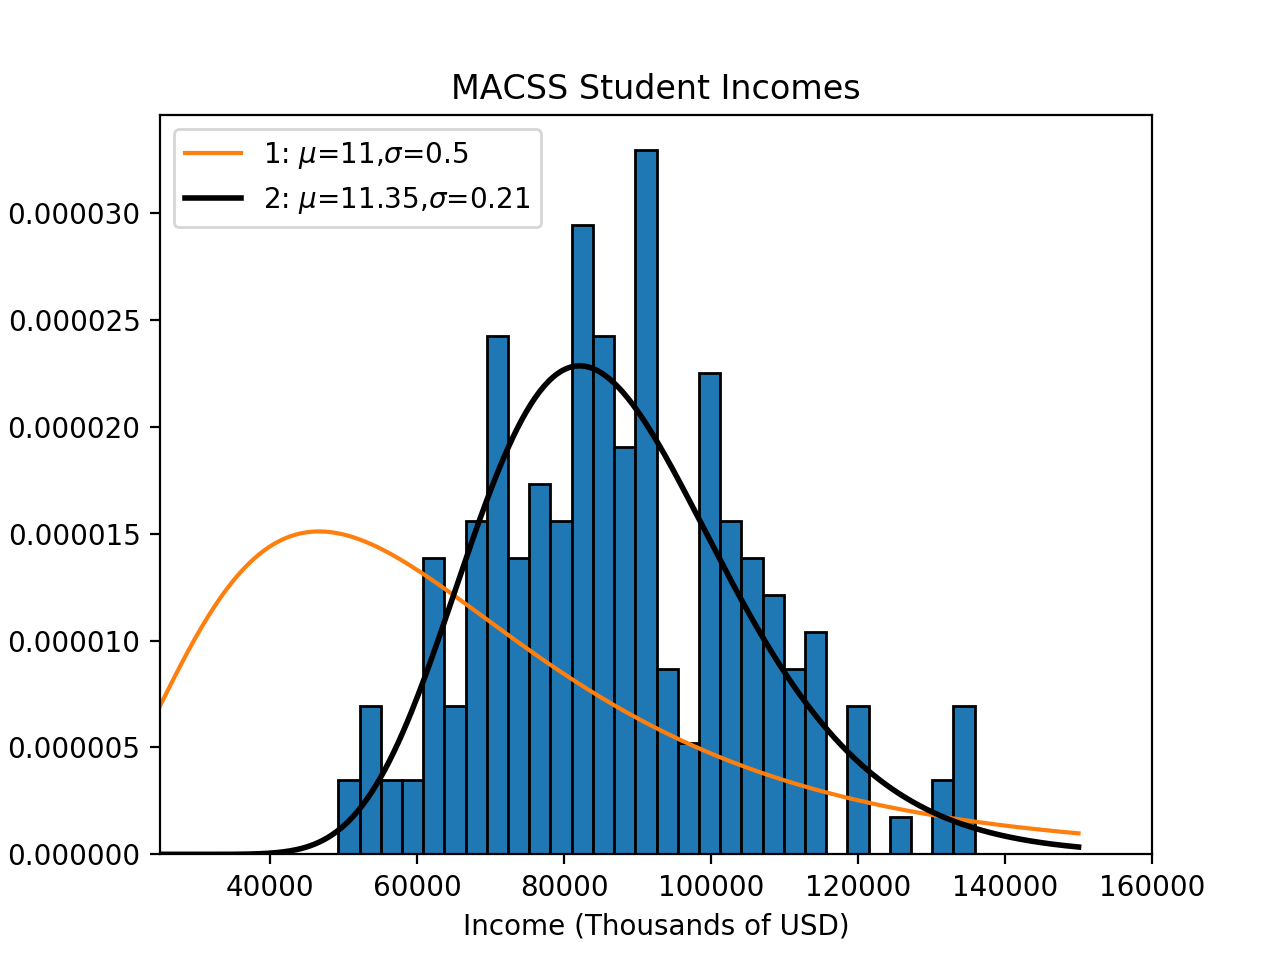

(25000, 160000)

In [78]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.hist(income, bins=30, edgecolor="black", normed=True)
plt.title("MACSS Graduates Income")
plt.xlabel("Yearly Income (thousands of USD)")
plt.ylabel("Percent of Graduates")
plt.xlim([25000, 160000])

## 1b) Plot the log normal probability distribution function (PDF).

In [79]:
def lognorm_pdf(xvals, mu, sigma, cutoff):
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals = (1/(xvals * siga * np.sqrt(2 * np.pi))) * np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)) / prob_notcut
        
    return pdf_vals

dist_pts = np.linspace(0.1, 150000, 500)
mu_1 = 11
sig_1 = 0.5
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_1, sig_1, 150000), label='1: $\mu$=11,$\sigma$=0.5')    
plt.title("MACSS Student Incomes")
plt.xlabel("Income (Thousands of USD)")
plt.ylabel("% of Observations")

In [80]:
def log_lik(xvals, mu, sigma, cutoff):
    pdf_vals = lognorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('The Log-likelihood Value for this parameterization is: ', log_lik(income, mu_1, sig_1, 150000))

The Log-likelihood Value for this parameterization is:  -2385.85699781


## 1c)  Estimate the parameters of the lognormal distribution by maximum likelihood.

In [81]:
def crit(params, *args):
    mu, sigma = params 
    #these are the values we are trying to minimize
    xvals, cutoff = args 
    #tuple of variable length arguments
    log_lik_val = log_lik(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val #return neg. log_like_val since problem is a minimization
    
    return neg_log_lik_val

In [82]:
import scipy.optimize as opt
# Minimize the results from the log-likelihood function

#initial guesses of values for parameters that minimize critereon function
mu_init = mu_1
sig_init = sig_1
params_init = np.array([mu_init, sig_init]) 

mle_args = (income, 150000) #tuple of arguments needed to solve critereon cunfciton
results = opt.minimize(crit, params_init, args=(mle_args), bounds=((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

mu_MLE= 11.3590243967  sig_MLE= 0.208178530156


In [83]:
print("The Maximum Likelihood Estimate (MLE) for mu is:", mu_MLE, ", the Maximum Likelihood Estimate (MLE) for sigma is:",
      sig_MLE, ", & the value for the log-likelihood function is:", log_lik(income, mu_MLE, sig_MLE, 150000))

The Maximum Likelihood Estimate (MLE) for mu is: 11.3590243967 , the Maximum Likelihood Estimate (MLE) for sigma is: 0.208178530156 , & the value for the log-likelihood function is: -2241.71930137


In [84]:
# Plot the MLE estimated distribution
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_MLE, sig_MLE, 15000),
         linewidth=2, color='k', label='2: $\mu$=11.35,$\sigma$=0.21')
plt.legend(loc='upper left')

In [89]:
# Variance Covariance matrix
results
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[  2.52831353e-04  -2.76208826e-05]
 [ -2.76208826e-05   1.30457089e-04]]
Standard error for mu estimate =  0.0159006714777
Standard error for sigma estimate =  0.0114217813365


## 1d) Perform a likelihood ratio test to determine probability that data from "incomes" came from distribution in Part b

In [91]:
log_lik_h0 = log_lik(income, mu_1, sig_1, 150000)
log_lik_mle = log_lik(income, mu_MLE, sig_MLE, 150000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


We can reject the null hypothesis with this result. 

## 1e) Using the estimated model from part c, what is the probability you will earn more than 100,000? What is the probability you will earn less than 75,000?

In [96]:
p_100000 = 1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
p_75000 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)
print(p_100000)
print(p_75000)

0.229870180558
0.260233297923


The probability that a MACSS graduate will earn more than 100,000 upon graduation is roughly 0.23. The probability that a MACSS graduate will earn less than 75,000 upon graduation is 0.26.

## 2a) Estimate the parameters of the model by maximum likelihood. 

In [195]:
# import data into data frame
import pandas as pd
df_sick = pd.read_csv('sick.txt')

sick = df_sick["sick"]
age = df_sick["age"]
children = df_sick["children"]
temp = df_sick["avgtemp_winter"]
variables = (sick, age, children, temp)

N = len(df_sick)

In [196]:
# calculate the error term
def get_error(parameters, variables):
    sick, age, children, temp = variables
    beta0, beta1, beta2, beta3, sigma = parameters
    error = np.sum((sick - beta0 - beta1*age - beta2*children - beta3*temp)**2)
    
    return error

In [199]:
# Calculate the log-likelihood value
def crit(params, *args):
    N=200
    beta0, beta1, beta2, beta3, sigma = params
    sick, age, children, temp = args
    error = get_error(params, args)
    log_lik_val = ((-N/2) * np.log(2*np.pi)) - (N*np.log(sigma)) - (1 / (2*sigma**2)) * (error)
    
    return - log_lik_val

In [215]:
import scipy.optimize as opt
# Minimize the results from the log-likelihood function
# initial guesses of values for parameters that minimize critereon function
beta0 = 0.5
beta1 = 0.3
beta2 = 0.2
beta3 = 0
sigma = 1
params_init = np.array([beta0, beta1, beta2, beta3, sigma]) 

mle_args = sick, age, children, temp

results = opt.minimize(crit, params_init, args=mle_args,  method = 'L-BFGS-B', bounds=((None, None),\
                       (None, None), (None, None), (None, None), (1e-10, None)))
                       
b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE = results.x

print('b0_MLE=', b0_MLE, 'b1_MLE=', b1_MLE, 'b2_MLE=', b2_MLE, 'b3_MLE=', b3_MLE, 'sig_MLE=', sig_MLE)

# log-likelihood estimate
# log_lik_estimate = crit((b0_MLE, b1_MLE, b2_MLE, b3_MLE, sig_MLE, sick, age, children, temp))

log_estimate = crit(params_init, sick, age, children, temp)
log_estimate

b0_MLE= 0.251644660734 b1_MLE= 0.0129334731331 b2_MLE= 0.400500998134 b3_MLE= -0.00999170702049 sig_MLE= 0.00301769355765


15655.262400140929

The estimates for the coefficients are as follows:
- beta0: 0.2516
- beta1: 0.0129
- beta2: 0.4005
- beta3: -0.0099
- sigma: 0.0030

The log likelihood estimate is 209.092

In [216]:
# Variance Covariance matrix
results
OffDiagNeg = np.eye(5)*2-1
vcv_mle = results.hess_inv.todense() * OffDiagNeg
print('VCV(MLE) = ', vcv_mle)

VCV(MLE) =  [[ 0.2485181  -0.02606061  0.2073393   0.02170961 -0.24621329]
 [-0.02606061  0.00278133  0.02176158  0.00233317 -0.02678593]
 [ 0.2073393   0.02176158  0.17299319 -0.01813459  0.20579474]
 [ 0.02170961  0.00233317 -0.01813459  0.00196255  0.02263704]
 [-0.24621329 -0.02678593  0.20579474  0.02263704  0.26321285]]


## 2b) Use likelihood ratio test to determine the probability that age, number of children, and avg. winter temperature will have no effect on the number of sick days.

In [218]:
beta0 = 0.5
beta1 = 0.3
beta2 = 0.2
beta3 = 0
sigma = 1
params_init = np.array([beta0, beta1, beta2, beta3, sigma])

log_lik_h0 = -crit(params_init, sick, age, children, temp)
log_lik_mle = -crit(results.x, sick, age, children, temp)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 5)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0)

chi squared of H0 with 2 degrees of freedom p-value =  0.0


Given that the p-value is 0.0, we can reject the null hypothesis.